# Linear Neural Network - Logistic Regression

In this notebook, we cast the Logistic Regression technique for Binary classification as a Linear Neural Network (LNN).

Using the LNN model we perform binary classification on a **linearly separable** data. Then, we visualize the decision boundary.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

import tensorflow as tf
from tensorflow import keras

np.random.seed(43)

## Decision Bounday: Using Various Thresholds for a Class Probability

We define a function to show the decision boundaries at various thresholds of a class probability. Using the different estimates for a single class, we generate a contour plot. 

In [2]:
def decision_boundary_class_colored(clf, X):
    
    # Get the min and max value of feature x1
    x1min, x1max = X[:,0].min() - 1, X[:, 0].max() + 1
    
    # Get the min and max value of feature x2
    x2min, x2max = X[:,1].min() - 1, X[:, 1].max() + 1
    
    # Create the mesh grid
    x1s = np.linspace(x1min, x1max, 100)
    x2s = np.linspace(x2min, x2max, 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    
    
    # Create pairs of new points from the grid
    X_new = np.c_[x1.ravel(), x2.ravel()]
    
    
    # Compute the class predictions for all new points    
    y_pred_proba = clf.predict(X_new).reshape(x1.shape)

    y_pred = y_pred_proba
            
    for i in range(y_pred_proba.shape[0]):
        for j in range(y_pred_proba.shape[1]):
            if(y_pred_proba[i][j] >= 0.5):
                y_pred[i][j] = 1
            else:
                y_pred[i][j] = 0
        
    # Generate the contourf plot for the predictions
    plt.contourf(x1, x2, y_pred, cmap=plt.cm.summer, alpha=0.9)

## Synthetic Dataset: Linearly Separable


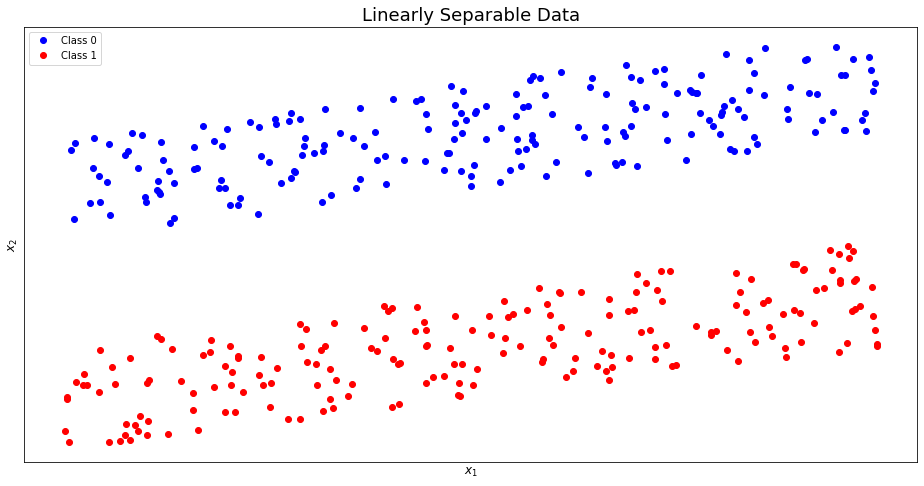

In [3]:
m0 = 200  # no. of training examples for class 0


# Generate class 0 data points randomly from a uniform distribution
#    Here a & b are 2 dimensions for each data (feature) point
a = np.random.rand(m0,1)
b = 4 + a + np.random.rand(m0,1)


# Concatenate the 2 dimensions of each feature to create the data matrix for class 0 
X0 = np.concatenate((a, b), axis=1)

# Create the target vector for class 0 (target is coded with zeros)
X0_target = np.zeros((m0,), dtype=np.int).reshape(-1, 1)


m1 = 200  # no. of training examples for class 1


# Generate class 1 data points randomly from a uniform distribution
#    Here c & d are 2 dimensions for each data (feature) point
c = np.random.rand(m1,1)
d = 6 + c + np.random.rand(m1,1)

# Concatenate the 2 dimensions of each feature to create the data matrix for class 1
X1 = np.concatenate((c, d), axis=1)


# Create the target vector for class 1 (target is coded with ones)
X1_target = np.ones((m1,), dtype=np.int).reshape(-1, 1)



# All training examples for class 0 and 1
X = np.append(X0, X1, axis=0)

# All target values for class 0 & 1
y = np.concatenate((X0_target, X1_target), axis=0)


# Create a 1D row vector ofthe target with float values
y = y.ravel()*1.0



# Draw a scatter plot
plt.figure(figsize=(16,8))
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bo", label="Class 0")
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "ro", label="Class 1")
plt.title("Linearly Separable Data", fontsize=18)
plt.legend(loc=2)
plt.xlabel("$x_1$", fontsize=12)
plt.ylabel("$x_2$", rotation=90, fontsize=12)
plt.xticks(())
plt.yticks(())
plt.show()

## Create a LNN Model

Using the Keras Dense layer we create the LNN model for Logistic Regression. **In a Dense layer, each neuron is connected to all input/neurons of the previous layer**.

The LNN model:
- has only one neuron.
- uses the logistic sigmoid function.

At first, we need to specify the shape of the input.

In [4]:
%%time

'''
Delete the TensorFlow graph before creating a new model, otherwise memory overflow will occur.
'''
keras.backend.clear_session()

'''
To reproduce the same result by the model in each iteration, we use fixed seeds for random number generation. 
'''
np.random.seed(42)
tf.random.set_seed(42)


'''
Create a Sequential model composed of a single stack of layers connected sequentially. 
'''
model = keras.models.Sequential(name="LNN_Binary_Classifier")
model.add(keras.layers.Input(shape=[2, ]))
model.add(keras.layers.Dense(units=1, kernel_initializer="he_normal", activation="sigmoid", use_bias=True))


model.summary()

Model: "LNN_Binary_Classifier"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1)                 3         
Total params: 3
Trainable params: 3
Non-trainable params: 0
_________________________________________________________________
CPU times: user 110 ms, sys: 6.73 ms, total: 117 ms
Wall time: 123 ms


## Compile & Train the LNN Model

In [5]:
'''
Define the optimizer
'''
optimizer = keras.optimizers.SGD(learning_rate=0.5)


'''
Compile the model
'''
model.compile(loss="binary_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])



no_of_epochs = 50
size_of_mini_batch = 64

history = model.fit(X, y, 
                    batch_size=size_of_mini_batch, 
                    epochs=no_of_epochs,
                    verbose=1)

Epoch 1/50
7/7 [==============================] - 0s 890us/step - loss: 2.4193 - accuracy: 0.4850
Epoch 2/50
7/7 [==============================] - 0s 826us/step - loss: 1.5931 - accuracy: 0.5500
Epoch 3/50
7/7 [==============================] - 0s 758us/step - loss: 1.7907 - accuracy: 0.4750
Epoch 4/50
7/7 [==============================] - 0s 743us/step - loss: 1.9581 - accuracy: 0.4950
Epoch 5/50
7/7 [==============================] - 0s 821us/step - loss: 1.7286 - accuracy: 0.5050
Epoch 6/50
7/7 [==============================] - 0s 869us/step - loss: 1.8348 - accuracy: 0.5100
Epoch 7/50
7/7 [==============================] - 0s 762us/step - loss: 1.5345 - accuracy: 0.5300
Epoch 8/50
7/7 [==============================] - 0s 788us/step - loss: 1.4583 - accuracy: 0.5000
Epoch 9/50
7/7 [==============================] - 0s 880us/step - loss: 1.5288 - accuracy: 0.5200
Epoch 10/50
7/7 [==============================] - 0s 814us/step - loss: 1.8291 - accuracy: 0.4700
Epoch 11/50
7/7 [==

## Evaluate the LNN Model

In [6]:
numOfEpochs = len(history.history['loss'])
print("Epochs: ", numOfEpochs)

print("\nTest Data: Loss & Accuracy: ", model.evaluate(X, y, verbose=0))


y_predicted_proba = model.predict(X)

print(len(y_predicted_proba))

y_predicted = y_predicted_proba

for i in range(len(y_predicted)):
    if(y_predicted_proba[i] >= 0.5):
        y_predicted[i] = 1
    else:
        y_predicted[i] = 0


y_predicted = y_predicted.ravel()
accuracy = np.mean(y_predicted == y)
print("\nAccuracy: ", accuracy)



print("\nConfusion Matrix:")
print(confusion_matrix(y, y_predicted))

print("\nClassification Report:")
print(classification_report(y, y_predicted))

Epochs:  50

Test Data: Loss & Accuracy:  [0.22881291806697845, 0.9225000143051147]
400

Accuracy:  0.9225

Confusion Matrix:
[[169  31]
 [  0 200]]

Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      0.84      0.92       200
         1.0       0.87      1.00      0.93       200

    accuracy                           0.92       400
   macro avg       0.93      0.92      0.92       400
weighted avg       0.93      0.92      0.92       400



## Plot The Decision Boundary

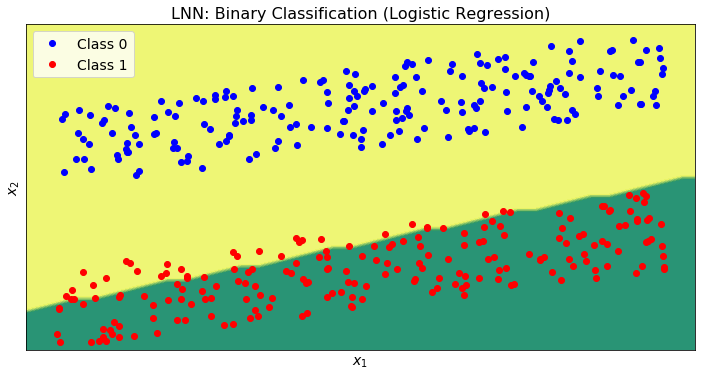

In [7]:
plt.figure(figsize=(12, 6))    

decision_boundary_class_colored(model, X)

plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bo", label="Class 0")
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "ro", label="Class 1")
plt.xlabel("$x_1$", fontsize=14)
plt.ylabel("$x_2$", fontsize=14)
plt.legend(loc="upper left", fontsize=14)
plt.title("LNN: Binary Classification (Logistic Regression)", fontsize=16)
plt.xticks(())
plt.yticks(())
plt.axis([-0.05, 1.05, 4, 8.05])

plt.show()